In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split,StratifiedKFold
import os
import keras
from keras import backend as K
from keras.utils import Sequence
from PIL import Image
import cv2
import albumentations
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D , MaxPool2D, UpSampling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization, Multiply
from keras.layers import LeakyReLU, Dense, GlobalAveragePooling2D, Lambda, GlobalMaxPooling2D
from keras.layers import ZeroPadding2D, Flatten
from keras.losses import binary_crossentropy
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, add, multiply
from keras.layers.merge import concatenate, add
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from classification_models import Classifiers
from tqdm import tqdm_notebook
import keras.callbacks as callbacks
import tensorflow as tf
import seaborn as sns
import shutil

from collections import defaultdict

Using TensorFlow backend.
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [11]:
train_img_dir = './rsnajpg512stage2/stage_2_train_images'
train_mask_dir = './rsnajpg512stage2/stage_2_train.csv'
test_img_dir = './rsnajpg512stage2/stage_2_test_images'
test_sub_dir = './rsnajpg512stage2/stage_2_sample_submission.csv'

epochs = 30
batch_size = 12
swa_nb = epochs-5

lr = 0.001
image_size = (256,256)


model_name = 'Class_base'

(512, 512, 3)


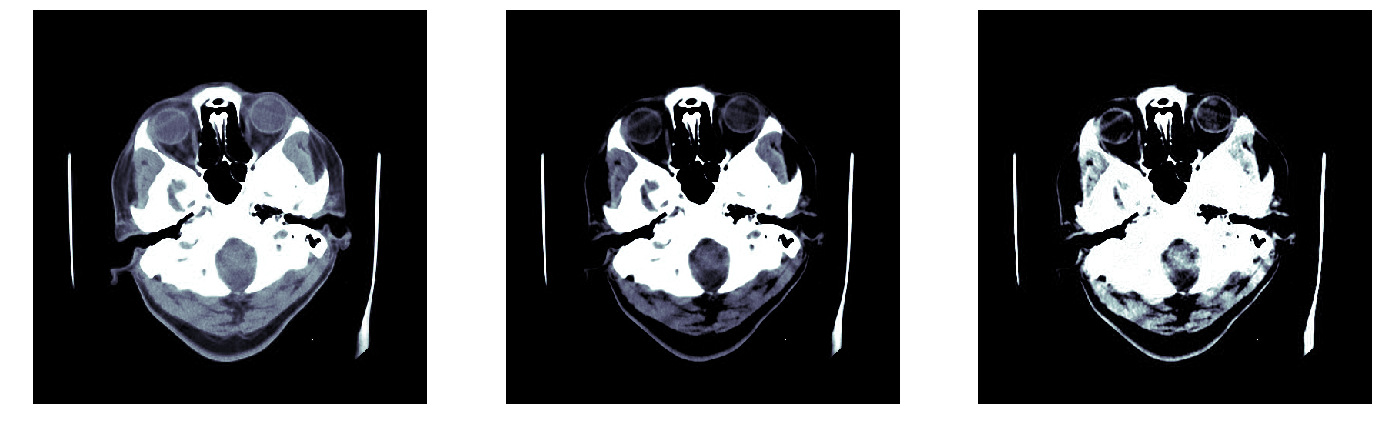

In [4]:
train_dir_image_check = glob.glob(train_img_dir+'/*')[0]
img = Image.open(train_dir_image_check)
img = np.array(img)
plt.figure(figsize=(24,8))
for i in range(3):
    plt.subplot(1,3,i+1), plt.imshow(img[:,:,i],cmap='bone')
    plt.axis('off')

print(np.array(img).shape)

# brain(40,80), subdural(80,200), soft(40,380)

In [7]:
cls_df = pd.read_csv(mask_dir)
cls_df.head(10)

ID  Label
0          ID_12cadc6af_epidural      0
1  ID_12cadc6af_intraparenchymal      0
2  ID_12cadc6af_intraventricular      0
3      ID_12cadc6af_subarachnoid      0
4          ID_12cadc6af_subdural      0
5               ID_12cadc6af_any      0
6          ID_38fd7baa0_epidural      0
7  ID_38fd7baa0_intraparenchymal      0
8  ID_38fd7baa0_intraventricular      0
9      ID_38fd7baa0_subarachnoid      0

In [8]:
cls_df.iloc[0:6,1].values.tolist()

[0, 0, 0, 0, 0, 0]

the number of images with no defects: 644874
the number of images with defects: 107933


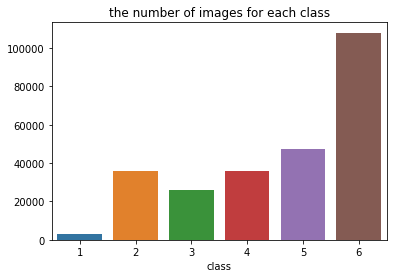

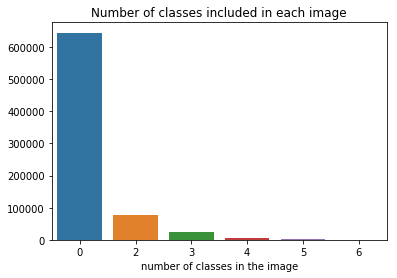

In [9]:
#https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda

class_dict = defaultdict(int)

kind_class_dict = defaultdict(int)

no_cls = 0
cls = 0

for col in range(0, len(cls_df), 6):
    img_names = [str(i).split("_")[0] for i in cls_df.iloc[col:col+6, 0].values]
    if not (img_names[0] == img_names[1] == img_names[2] == img_names[3] == img_names[4] == img_names[5]):
        raise ValueError
        
    labels = cls_df.iloc[col:col+6, 1]
    check = labels.sum()
    kind_class_dict[check]+=1
    if check == 0:
        no_cls += 1
    else:
        cls += 1

    for idx, label in enumerate(labels.values.tolist()):
        if label == 1:
            class_dict[idx+1] += 1
            
print("the number of images with no defects: {}".format(no_cls))
print("the number of images with defects: {}".format(cls))


fig, ax = plt.subplots()
sns.barplot(x=list(class_dict.keys()), y=list(class_dict.values()), ax=ax)
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
class_dict


fig, ax = plt.subplots()
sns.barplot(x=list(kind_class_dict.keys()), y=list(kind_class_dict.values()), ax=ax)
ax.set_title("Number of classes included in each image");
ax.set_xlabel("number of classes in the image")
kind_class_dict

In [12]:
def read_testset(filename = test_sub_dir):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    return df

def read_trainset(filename = train_mask_dir):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    duplicates_to_remove = [
        56340, 56341, 56342, 56343, 56344, 56345, 56346, 56347, 56348, 56349, 56350,
        56351, 1171824, 1171825, 1171826, 1171827, 1171828, 1171829, 1171830, 1171831,
        1171832, 1171833, 1171834, 1171835, 3705306, 3705307, 3705308, 3705309, 3705310,
        3705311, 3705312, 3705313, 3705314, 3705315, 3705316, 3705317, 3842472, 3842473,
        3842474, 3842475, 3842476, 3842477, 3842478, 3842479, 3842480, 3842481, 3842482, 3842483
    ]
    df = df.drop(index = duplicates_to_remove)
    df = df.reset_index(drop = True)    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    return df

# Read Train and Test Datasets
test_df = read_testset()
train_df = read_trainset()

In [16]:
train_df.head(20)

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   
ID_0000aee4b     0        0                0                0            0   
ID_0000ca2f6     0        0                0                0            0   
ID_0000f1657     0        0                0                0            0   
ID_000178e76     0        0                0                0            0   
ID_00019828f     0        0                0                0            0   
ID_0001dcc25     0        0                0                0            0   
ID_0001de0e8     0        0                0                0            0   
ID_0001f7f62     0        0                0                0            0   
ID_0002003a8     0        0                0                0            0   
ID_0002081b6     1        0                1                0            0   
ID_0002108bd     0        0                0                0            0   
ID_000229f2a     0        0                0                0            0   
ID_000230ed7     0        0                0                0            0   
ID_000259ccf     0        0                0                0            0   
ID_00025ef4b     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0  
ID_0000aee4b        0  
ID_0000ca2f6        0  
ID_0000f1657        0  
ID_000178e76        0  
ID_00019828f        0  
ID_0001dcc25        0  
ID_0001de0e8        0  
ID_0001f7f62        0  
ID_0002003a8        0  
ID_0002081b6        0  
ID_0002108bd        0  
ID_000229f2a        0  
ID_000230ed7        0  
ID_000259ccf        0  
ID_00025ef4b        0

In [22]:
aaa = np.empty((2,6))
train_df.loc['ID_0002081b6'].values

array([1, 0, 1, 0, 0, 0], dtype=int64)

In [24]:
aaa[0]=train_df.loc['ID_0002081b6'].values
aaa

array([[ 1.,  0.,  1.,  0.,  0.,  0.],
       [nan, nan, nan, nan, nan, nan]])

In [31]:
class Datagen(Sequence):
    def __init__(self, train_dir = train_img_dir, label_df = train_df, augmentation = None,
                 batch_size = batch_size, shuffle = True, image_size = image_size, preprocess = None, subset = 'train'):
        self.train_dir = train_dir
        self.train_dirs = glob.glob(train_dir+'/*')
        self.label_df = label_df
        self.augment = augmentation
        self.batch_size = batch_size
        self.shuffle = shuffle            
        self.image_size = image_size
        self.subset = subset
        self.preprocess = preprocess   ## imagenet preprocess
        self.on_epoch_end()

    def __getitem__(self,index):
        # get the indexes
        indexes = self.indexes[(index)*self.batch_size:min((index+1)*self.batch_size,len(self.train_dirs))]

        # list of items
        list_id_items = [self.train_dirs[x] for x in indexes]
        image, label = self._data_generator(list_id_items)

        if self.augment is None:
            if self.subset == 'train': return image, label
            else: return image
        else:
            images = [] 
            for x in image:
                augment_result = self.augment(image = x)
                images.append(augment_result['image'])
            if self.subset == 'train': return np.array(images), label
            else: return np.array(images)
        
    def __len__(self):
        return int(np.ceil(len(self.train_dirs)/self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.train_dirs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def _data_generator(self,list_id_items):
        batch_size = len(list_id_items)
        images = np.empty((batch_size, *self.image_size, 3))
        labels = np.empty((batch_size,6))
        for i , data in enumerate(list_id_items):
            # get source image
 
            im = cv2.resize(np.array(Image.open(data)),self.image_size)
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

            if self.subset == 'train': 
                d_name = data.split('\\')[-1]
                label = self.label_df.loc[d_name.split('.')[0]].values
                
            if self.preprocess!=None: im = self.preprocess(im)
            images[i,] = im
            labels[i,] = label
            
        return np.uint8(images), labels

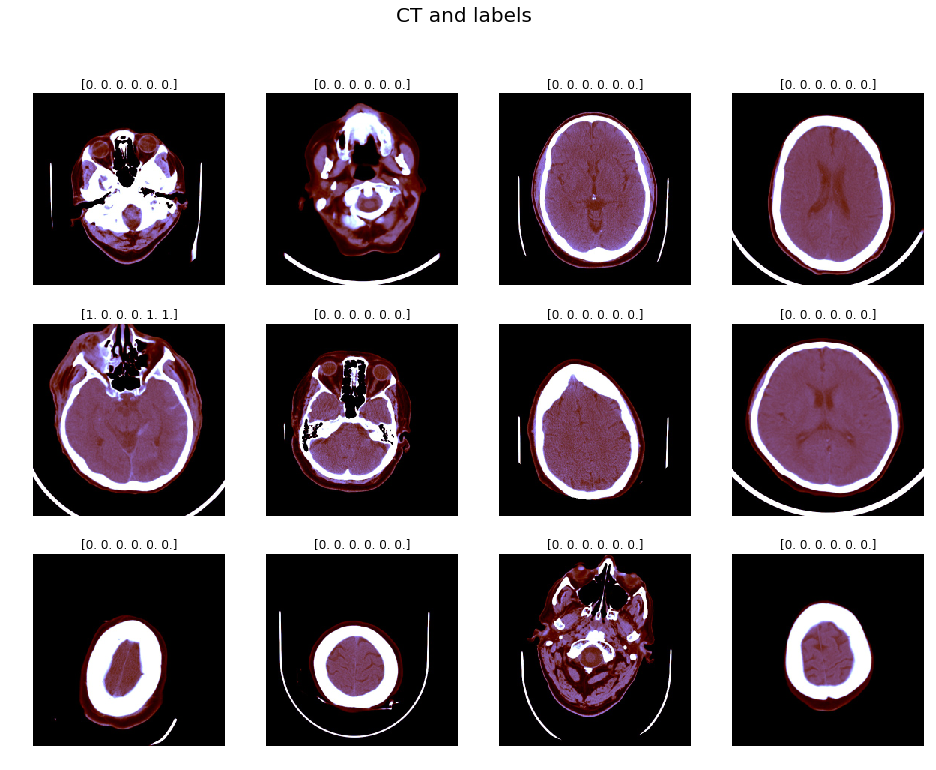

In [34]:
def print_test_data(data_gen , total_image , augmentation = None , shuffle = False):
    Dgen = data_gen(batch_size=total_image, shuffle=shuffle ,augmentation = augmentation)
    images, labels = Dgen.__getitem__(0)
    fig_width = 4
    fig_height = int(total_image/fig_width)
    fig, axes = plt.subplots(fig_height,fig_width,figsize=(fig_width*4,fig_height*4))

    for i, (im , lb) in enumerate(zip(images,labels)):
        ax = axes[int(i/fig_width),i%fig_width]
        ax.imshow(im.squeeze().astype('uint8'))
        ax.title.set_text(lb)
        ax.axis('off')
    plt.suptitle("CT and labels",fontsize=20)
    
print_test_data(Datagen,12,shuffle= False)

In [35]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)
AUGMENTATIONS_TRAIN = Compose([    
    HorizontalFlip(),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
    ], p=0.3),
    ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10)],p=1)


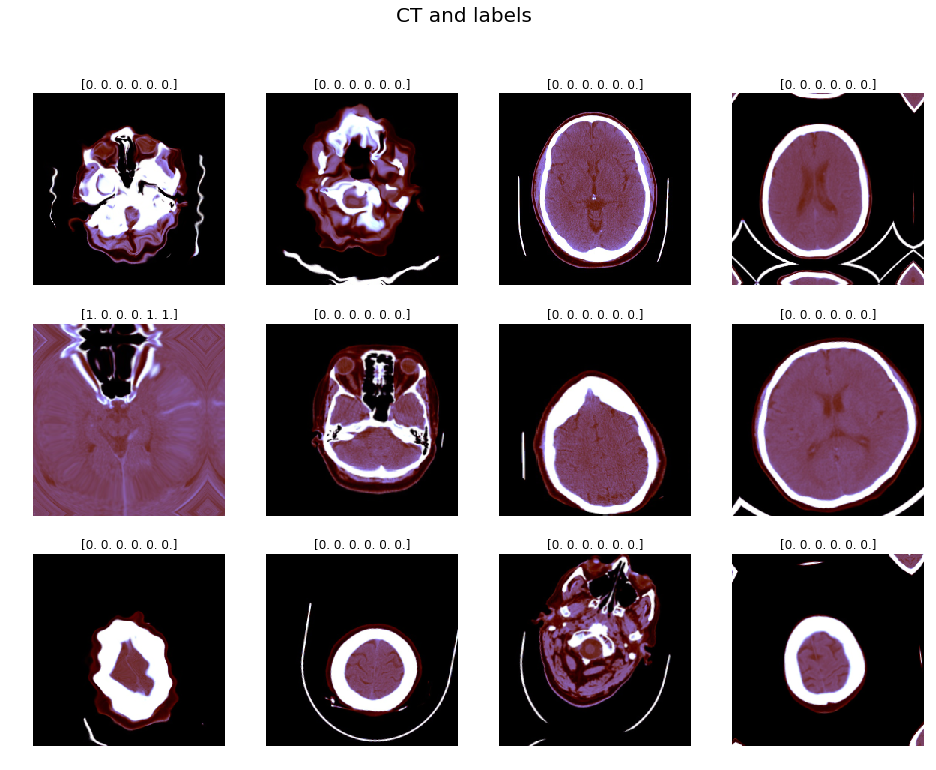

In [36]:
print_test_data(Datagen,12,augmentation = AUGMENTATIONS_TRAIN ,shuffle= False)

In [29]:
def cbam_block(cbam_feature, channel, ratio = 4, kernel_size = 7):

    cbam_feature = channel_attention(cbam_feature, channel, ratio)
    cbam_feature = spatial_attention(cbam_feature, kernel_size)
    return cbam_feature

def channel_attention(input_feature, channel, ratio=4):

    shared_layer_one = Dense(channel//ratio, activation='relu')
    shared_layer_two = Dense(channel)

    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = shared_layer_one(max_pool)  
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature,kernel_size):

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    
    cbam_feature = Conv2D(filters = 1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          use_bias=False)(concat)

    return multiply([input_feature, cbam_feature])

In [30]:
def cbam_convolution_block(x, filters, size=(3,3), strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = cbam_block(x,filters)
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = cbam_block(x,filters)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = BatchNormalization()(blockInput)
    x = LeakyReLU(alpha=0.1)(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

def attn_block(signal,blockInput):
    signal_shape = K.int_shape(signal)
    blockInput_shape = K.int_shape(blockInput)
    
    #signal = Conv2D(signal_shape[3], (1,1), strides=(1,1), padding='same')(signal)
    #signal = BatchNormalization()(signal)
    #signal = LeakyReLU(alpha=0.1)(signal)
    
    signal = Conv2D(blockInput_shape[3], (1,1), strides=(1,1), padding='same')(signal)
    theta_Input = Conv2D(blockInput_shape[3], (2,2), 
                         strides=(blockInput_shape[1]//signal_shape[1],blockInput_shape[2]//signal_shape[2]), 
                         padding='same')(blockInput)
    
    Add_s_t = Add()([theta_Input, signal])
    Add_s_t = BatchNormalization()(Add_s_t)
    Add_s_t = Activation('relu')(Add_s_t)
    Add_s_t = Conv2D(1, (1,1), strides=(1,1), padding='same')(Add_s_t)
    Add_s_t = BatchNormalization()(Add_s_t)
    Add_s_t = Activation('sigmoid')(Add_s_t)
    
    Add_s_t = UpSampling2D(size=(blockInput_shape[1]//signal_shape[1],blockInput_shape[2]//signal_shape[2]))(Add_s_t)
    
    OutputL = Multiply()([blockInput,Add_s_t])
    
    return OutputL

In [31]:
from classification_models import Classifiers
seresnext50, preprocess_input_se = Classifiers.get('seresnext50')

def USNEXT50(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = seresnext50(weights='imagenet', include_top=False,
                              input_shape=input_shape, classes = 4)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.get_layer('activation_67').output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = cbam_convolution_block(convm,start_neurons * 32)
    convm = cbam_convolution_block(convm,start_neurons * 32)

    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = cbam_convolution_block(uconv4,start_neurons * 16)

    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.get_layer('activation_37').output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = cbam_convolution_block(uconv3,start_neurons * 8)


    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.get_layer('activation_17').output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = cbam_convolution_block(uconv2,start_neurons * 4)

    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.get_layer('activation_1').output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = cbam_convolution_block(uconv1,start_neurons * 2)

    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = cbam_convolution_block(uconv0,start_neurons * 1)

    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(4, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'USNEXT50'

    return model

In [32]:
from efficientnet import EfficientNetB4


def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet', include_top=False,
                              input_shape=input_shape, classes = 4)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = cbam_convolution_block(convm,start_neurons * 32)
    convm = cbam_convolution_block(convm,start_neurons * 32)

    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = cbam_convolution_block(uconv4,start_neurons * 16)

    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = cbam_convolution_block(uconv3,start_neurons * 8)


    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = cbam_convolution_block(uconv2,start_neurons * 4)

    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = cbam_convolution_block(uconv1,start_neurons * 2)

    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = cbam_convolution_block(uconv0,start_neurons * 1)

    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(4, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'UEfficientNet'

    return model

In [33]:
ResNet34, preprocess_input = Classifiers.get('resnet34')

def UResNet34(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = ResNet34(weights='imagenet', include_top=False,
                              input_shape=input_shape, classes = 4)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.get_layer('stage4_unit1_relu1').output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = cbam_convolution_block(convm,start_neurons * 32)
    convm = cbam_convolution_block(convm,start_neurons * 32)

    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = cbam_convolution_block(uconv4,start_neurons * 16)

    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.get_layer('stage3_unit1_relu1').output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = cbam_convolution_block(uconv3,start_neurons * 8)


    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.get_layer('stage2_unit1_relu1').output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = cbam_convolution_block(uconv2,start_neurons * 4)

    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.get_layer('relu0').output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = cbam_convolution_block(uconv1,start_neurons * 2)

    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = cbam_convolution_block(uconv0,start_neurons * 1)

    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(4, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'UResNet34'

    return model

In [34]:
K.clear_session()
model = UEfficientNet(input_shape=(image_size[0]//shrink,image_size[1]//shrink,3),dropout_rate=0.5)
#model = UResNet34(input_shape=(image_size[0]//shrink,image_size[1]//shrink,3),dropout_rate=0.5)
#model = USNEXT50(input_shape=(image_size[0]//shrink,image_size[1]//shrink,3),dropout_rate=0.5)
model.summary()

model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[dice_coef])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 400, 48)  1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (Non

__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 32, 200, 32)  128         conv2d_19[0][0]                  
__________________________________________________________________________________________________
drop_connect_3 (DropConnect)    (None, 32, 200, 32)  0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
add_3 (Add)                     (None, 32, 200, 32)  0           drop_connect_3[0][0]             
                                                                 add_2[0][0]                      
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 200, 192) 6144        add_3[0][0]                      
__________________________________________________________________________________________________
batch_norm

conv2d_39 (Conv2D)              (None, 16, 100, 56)  18816       multiply_10[0][0]                
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 16, 100, 56)  224         conv2d_39[0][0]                  
__________________________________________________________________________________________________
drop_connect_7 (DropConnect)    (None, 16, 100, 56)  0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
add_7 (Add)                     (None, 16, 100, 56)  0           drop_connect_7[0][0]             
                                                                 add_6[0][0]                      
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 16, 100, 336) 18816       add_7[0][0]                      
__________

__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 8, 50, 112)   75264       multiply_15[0][0]                
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 8, 50, 112)   448         conv2d_59[0][0]                  
__________________________________________________________________________________________________
drop_connect_11 (DropConnect)   (None, 8, 50, 112)   0           batch_normalization_44[0][0]     
__________________________________________________________________________________________________
add_11 (Add)                    (None, 8, 50, 112)   0           drop_connect_11[0][0]            
                                                                 add_10[0][0]                     
__________________________________________________________________________________________________
conv2d_60 

                                                                 swish_58[0][0]                   
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 8, 50, 160)   153600      multiply_20[0][0]                
__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 8, 50, 160)   640         conv2d_79[0][0]                  
__________________________________________________________________________________________________
drop_connect_15 (DropConnect)   (None, 8, 50, 160)   0           batch_normalization_59[0][0]     
__________________________________________________________________________________________________
add_15 (Add)                    (None, 8, 50, 160)   0           drop_connect_15[0][0]            
                                                                 add_14[0][0]                     
__________

__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 4, 25, 256)   590080      multiply_36[0][0]                
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, 4, 25, 256)   1024        conv2d_133[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 4, 25, 256)   0           batch_normalization_99[0][0]     
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 256)          0           leaky_re_lu_4[0][0]              
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 256)          0           leaky_re_lu_4[0][0]              
__________

conv2d_142 (Conv2D)             (None, 16, 100, 64)  304192      dropout_3[0][0]                  
__________________________________________________________________________________________________
conv2d_143 (Conv2D)             (None, 16, 100, 64)  36928       conv2d_142[0][0]                 
__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 16, 100, 64)  256         conv2d_143[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 16, 100, 64)  0           batch_normalization_103[0][0]    
__________________________________________________________________________________________________
global_average_pooling2d_7 (Glo (None, 64)           0           leaky_re_lu_8[0][0]              
__________________________________________________________________________________________________
global_max

__________________________________________________________________________________________________
conv2d_transpose_7 (Conv2DTrans (None, 64, 400, 64)  36928       conv2d_transpose_6[0][0]         
__________________________________________________________________________________________________
conv2d_transpose_4 (Conv2DTrans (None, 64, 400, 128) 147584      conv2d_transpose_3[0][0]         
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 64, 400, 384) 0           conv2d_transpose_10[0][0]        
                                                                 conv2d_transpose_9[0][0]         
                                                                 conv2d_transpose_7[0][0]         
                                                                 conv2d_transpose_4[0][0]         
                                                                 swish_6[0][0]                    
__________

__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 128, 800, 8)  0           multiply_60[0][0]                
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 128, 800, 4)  36          dropout_7[0][0]                  
Total params: 11,622,476
Trainable params: 11,568,860
Non-trainable params: 53,616
__________________________________________________________________________________________________


In [35]:
#from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing
#
## LOAD UNET WITH PRETRAINING FROM IMAGENET
#preprocess = get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0
#model = Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
#model.summary

In [34]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save(self.filepath)
        print('Final stochastic averaged model saved to file.')

In [35]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.001, monitors = 'val_acc'):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr
        self.monitors = monitors

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint(model_name+'.h5',monitor=self.monitors, 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [35]:
#from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing
#
#
#preprocess = get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0
#model = Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
#model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
#

In [36]:
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3, 'val_dice_coef')
swa = SWA(model_name+'_swa.h5',swa_nb)

# Generators
training_generator = Datagen(augmentation=AUGMENTATIONS_TRAIN,
                             image_size=image_size,batch_size=batch_size,
                             shrink=shrink,preprocess = preprocess_input_se)

validation_generator = Datagen(train_dir = VAL_DIR,
                               augmentation=AUGMENTATIONS_TEST,
                               image_size=image_size,batch_size=batch_size,
                               shrink=shrink, preprocess = preprocess_input_se)

history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,  
                              use_multiprocessing=False,
                              epochs=epochs,verbose=2,
                              callbacks=snapshot.get_callbacks())

Instructions for updating:
Use tf.cast instead.
Stochastic weight averaging selected for last 3 epochs.
Epoch 1/70
 - 1375s - loss: 0.1797 - dice_coef: 0.0265 - val_loss: 0.0306 - val_dice_coef: 0.1113

Epoch 00001: val_dice_coef improved from -inf to 0.11132, saving model to Uefficientnet_bce.h5
Epoch 2/70
 - 1330s - loss: 0.0296 - dice_coef: 0.1302 - val_loss: 0.0225 - val_dice_coef: 0.2088

Epoch 00002: val_dice_coef improved from 0.11132 to 0.20880, saving model to Uefficientnet_bce.h5
Epoch 3/70
 - 1335s - loss: 0.0246 - dice_coef: 0.2179 - val_loss: 0.0216 - val_dice_coef: 0.1082

Epoch 00003: val_dice_coef did not improve from 0.20880
Epoch 4/70
 - 1334s - loss: 0.0226 - dice_coef: 0.2467 - val_loss: 0.0195 - val_dice_coef: 0.0708

Epoch 00004: val_dice_coef did not improve from 0.20880
Epoch 5/70
 - 1336s - loss: 0.0218 - dice_coef: 0.2811 - val_loss: 0.0173 - val_dice_coef: 0.5088

Epoch 00005: val_dice_coef improved from 0.20880 to 0.50876, saving model to Uefficientnet_bce.h


Epoch 00048: val_dice_coef did not improve from 0.64319
Epoch 49/70
 - 1339s - loss: 0.0105 - dice_coef: 0.5963 - val_loss: 0.0105 - val_dice_coef: 0.6335

Epoch 00049: val_dice_coef did not improve from 0.64319
Epoch 50/70
 - 1338s - loss: 0.0104 - dice_coef: 0.5943 - val_loss: 0.0106 - val_dice_coef: 0.6281

Epoch 00050: val_dice_coef did not improve from 0.64319
Epoch 51/70
 - 1339s - loss: 0.0104 - dice_coef: 0.5944 - val_loss: 0.0104 - val_dice_coef: 0.6248

Epoch 00051: val_dice_coef did not improve from 0.64319
Epoch 52/70
 - 1338s - loss: 0.0102 - dice_coef: 0.5958 - val_loss: 0.0104 - val_dice_coef: 0.6404

Epoch 00052: val_dice_coef did not improve from 0.64319
Epoch 53/70
 - 1338s - loss: 0.0102 - dice_coef: 0.6025 - val_loss: 0.0102 - val_dice_coef: 0.6399

Epoch 00053: val_dice_coef did not improve from 0.64319
Epoch 54/70
 - 1338s - loss: 0.0101 - dice_coef: 0.6025 - val_loss: 0.0106 - val_dice_coef: 0.6144

Epoch 00054: val_dice_coef did not improve from 0.64319
Epoch 5

Text(0.5, 1.0, 'model loss')

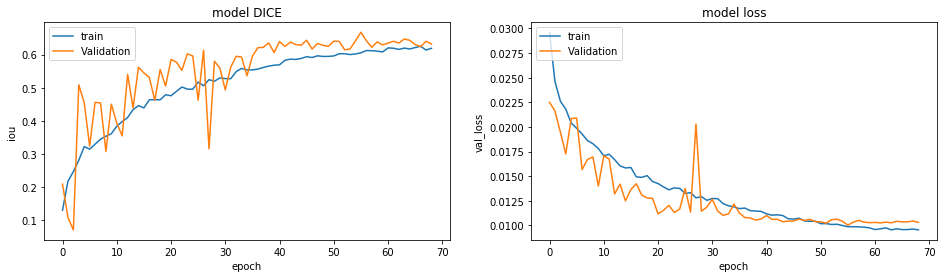

In [37]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['dice_coef'][1:])
plt.plot(history.history['val_dice_coef'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model DICE')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
#gc.collect()

In [82]:
def predict_result(model,validation_generator): 
    preds_test1 = model.predict_generator(validation_generator)
    return preds_test1

In [83]:
val_image_list = glob.glob(VAL_DIR+'/*')
len(val_image_list)

1886

In [84]:
def get_val_set_image():
    val_image_list = glob.glob(VAL_DIR+'/*')
    mask_df = pd.read_csv(mask_dir)
    mask_df.set_index('ImageId_ClassId',inplace=True)
    total_image = len(val_image_list)
    val_mask_img = np.zeros((total_image, image_size[0]//shrink, image_size[1]//shrink, 4))
    for i, data in enumerate(val_image_list): 
        d_name = data.split('\\')[-1]
        for idx in range(4):
            rle = mask_df.loc[d_name+'_{}'.format(idx+1),'EncodedPixels']
            val_mask_img[i,:,:,idx] = rle2mask(rle,image_size,shrink)
    return val_mask_img


val_img = get_val_set_image()

In [96]:
from keras.models import load_model
model.load_weights(model_name+'_swa.h5')

In [97]:
def get_predict_image():
    
    validation_generator = Datagen(train_dir = VAL_DIR,
                                   augmentation=AUGMENTATIONS_TEST,
                                   image_size=image_size,shuffle=False,subset = 'val')

    AUGMENTATIONS_TEST_FLIPPED = Compose([HorizontalFlip(p=1),ToFloat(max_value=1)],p=1)

    validation_generator_flipped = Datagen(train_dir = VAL_DIR,
                                           augmentation=AUGMENTATIONS_TEST_FLIPPED,
                                           image_size=image_size,shuffle=False,subset = 'val')
    
    preds_valid_orig = model.predict_generator(validation_generator)
    preds_valid_flipped = model.predict_generator(validation_generator_flipped)
    preds_valid_flipped = np.array([np.fliplr(x) for x in preds_valid_flipped])
    preds_valid = 0.5*preds_valid_orig + 0.5*preds_valid_flipped
    
    return preds_valid

pre_img = get_predict_image()

In [98]:
assert pre_img.shape == val_img.shape

In [99]:
def draw_predict_image(total_image=20,random = True):
    val_image_list = glob.glob(VAL_DIR+'/*')
    if random is True:
        indexes = np.random.randint(0,val_img.shape[0],total_image)
    else:
        indexes = np.arange(0,total_image)
    for idx in range(total_image):
        idx = indexes[idx]
        plt.figure(figsize=(20,12))
        plt.subplot(5,1,1),plt.imshow(np.array(Image.open(val_image_list[idx]))),plt.axis('off')
        for classes in range(4):
            plt.subplot(5,2,classes*2+3),plt.imshow(val_img[idx,:,:,classes],cmap='bone'),plt.axis('off')
            plt.subplot(5,2,classes*2+4),plt.imshow(pre_img[idx,:,:,classes]),plt.axis('off')
        plt.suptitle(val_image_list[idx].split('\\')[-1],fontsize=30)

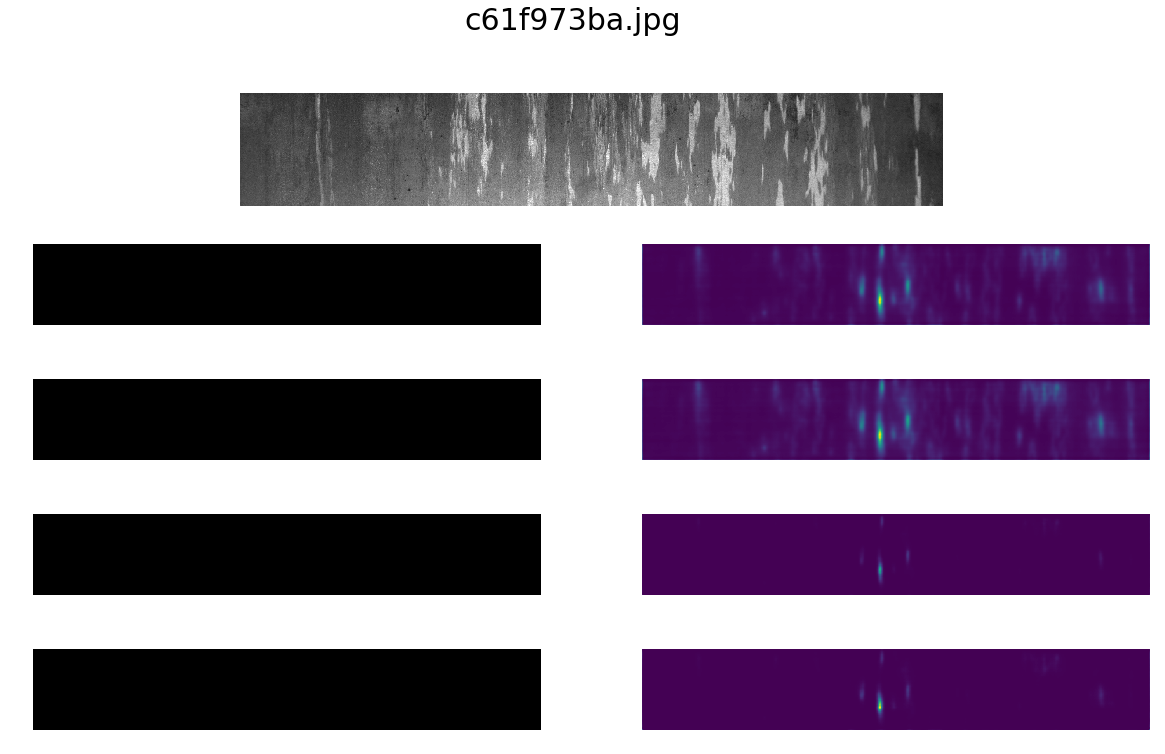

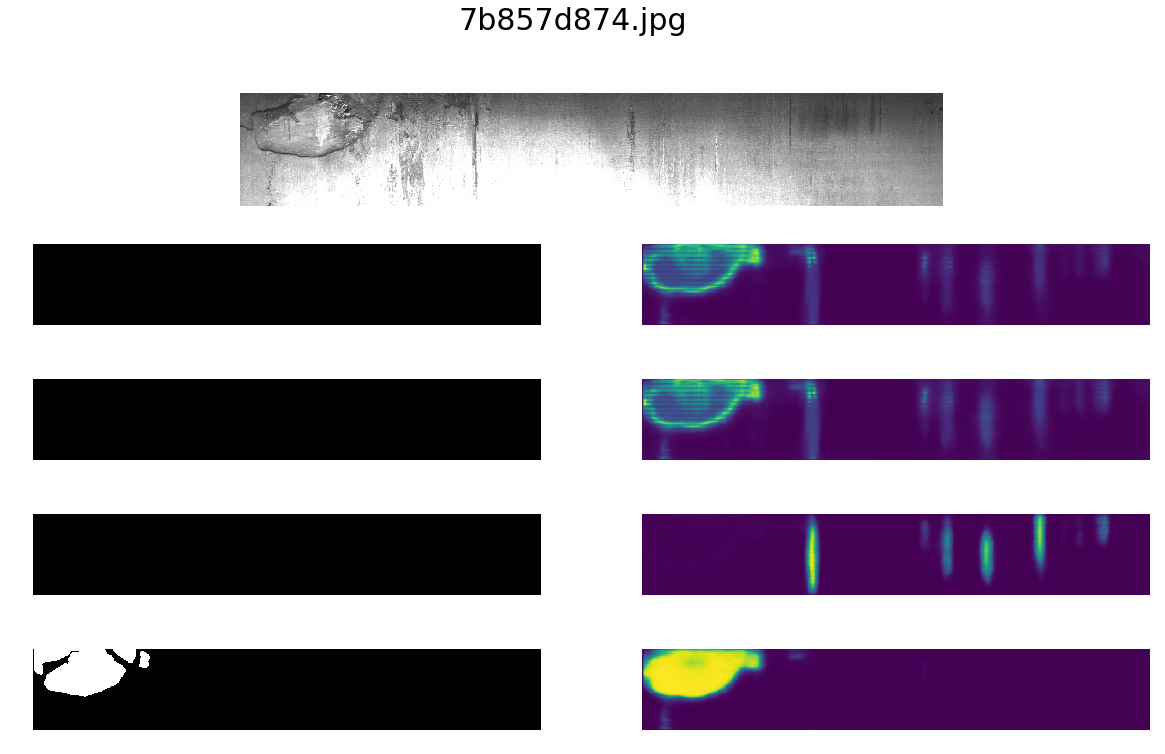

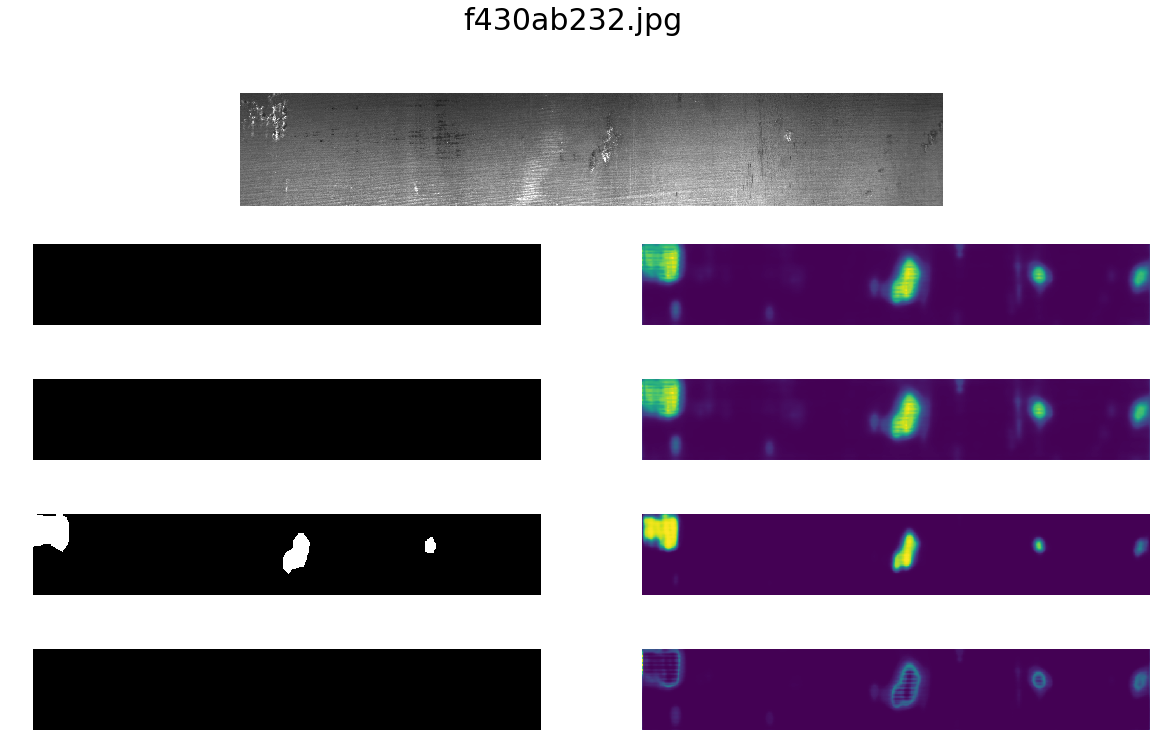

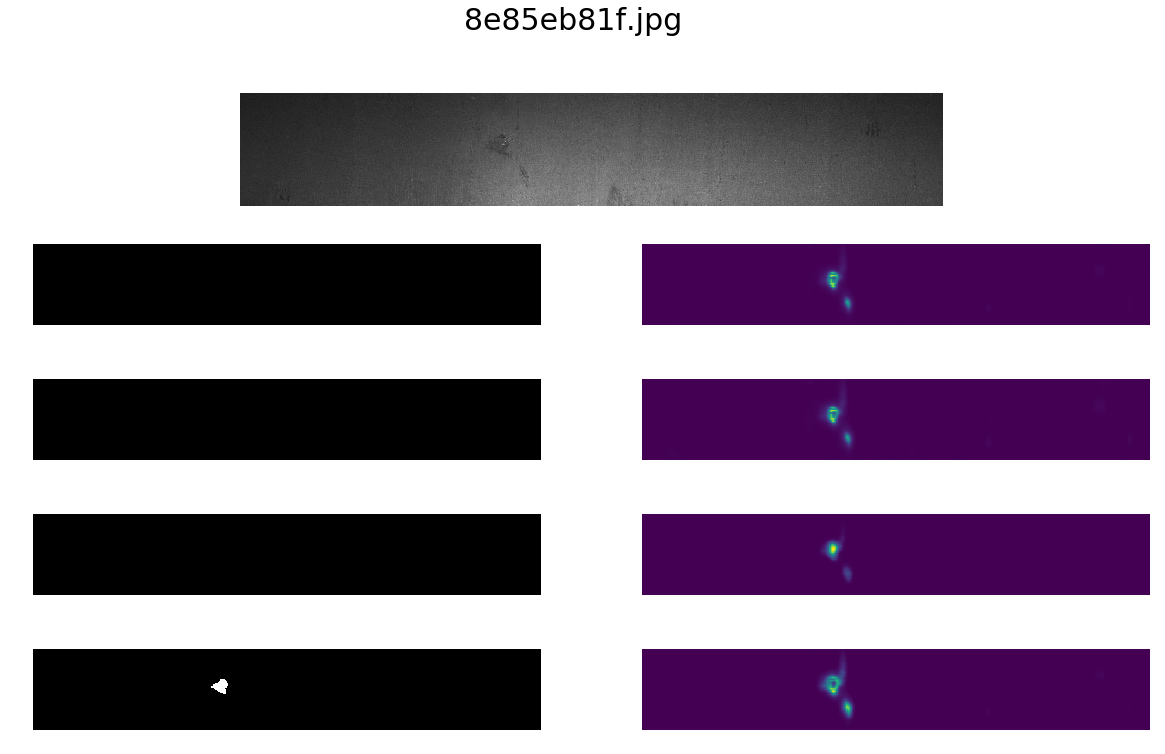

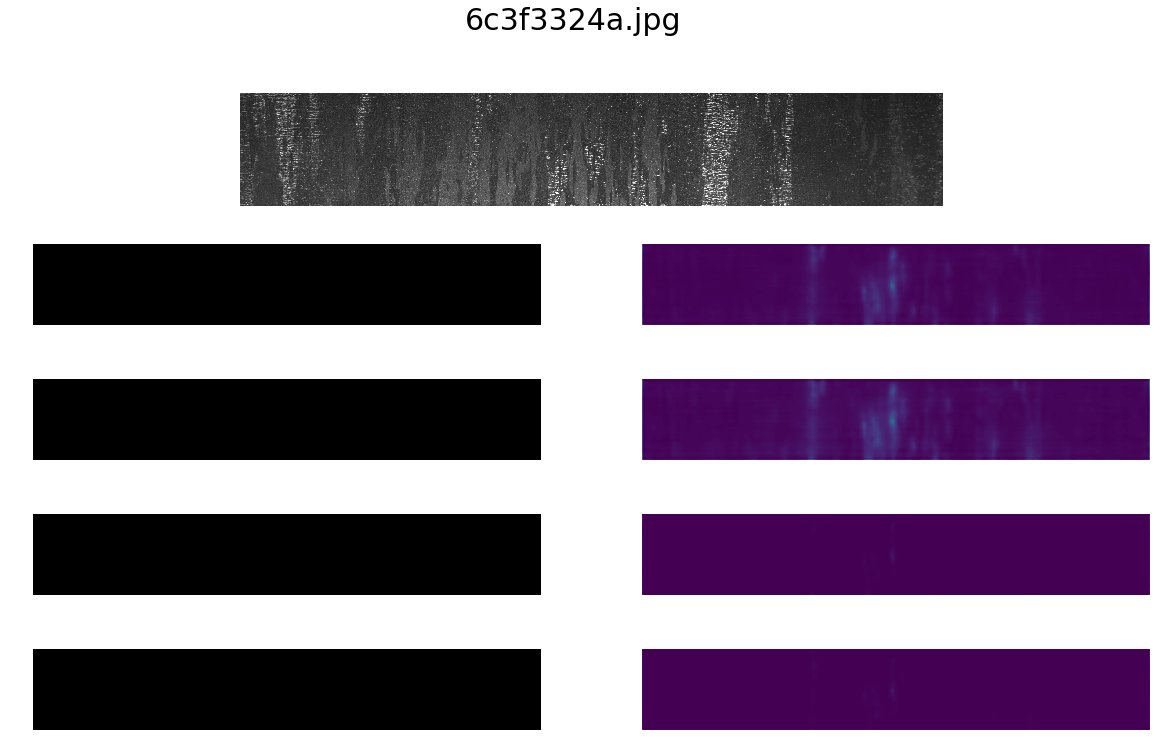

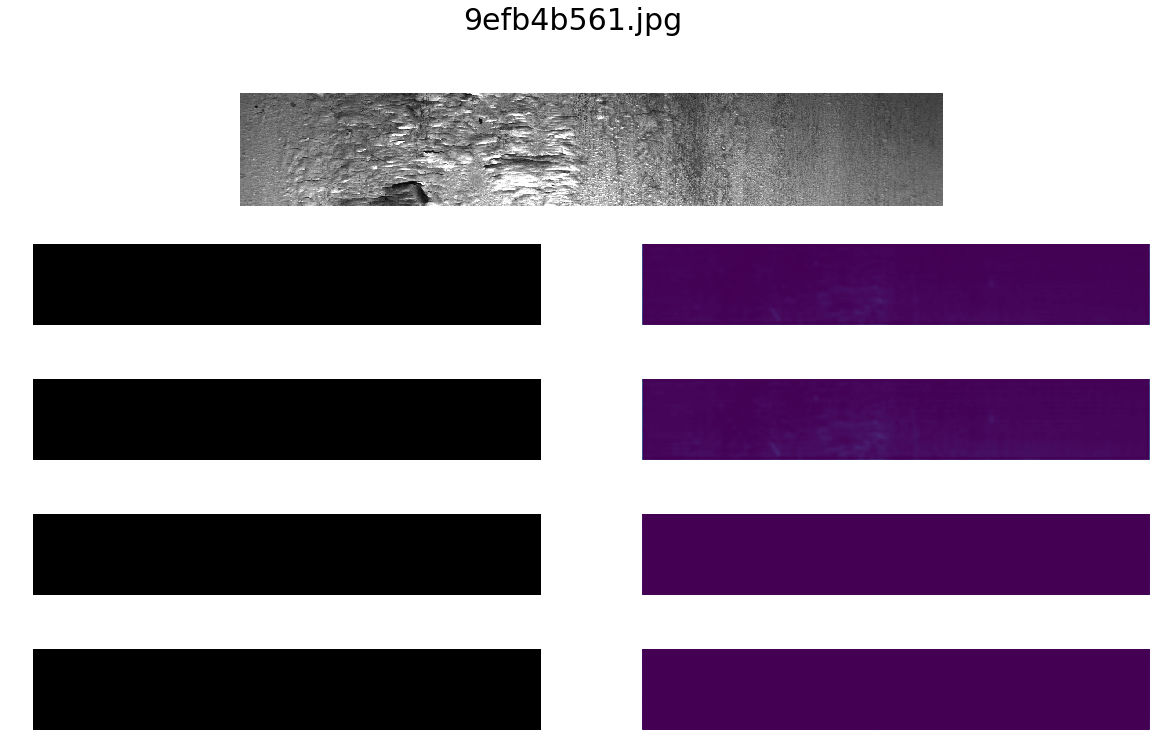

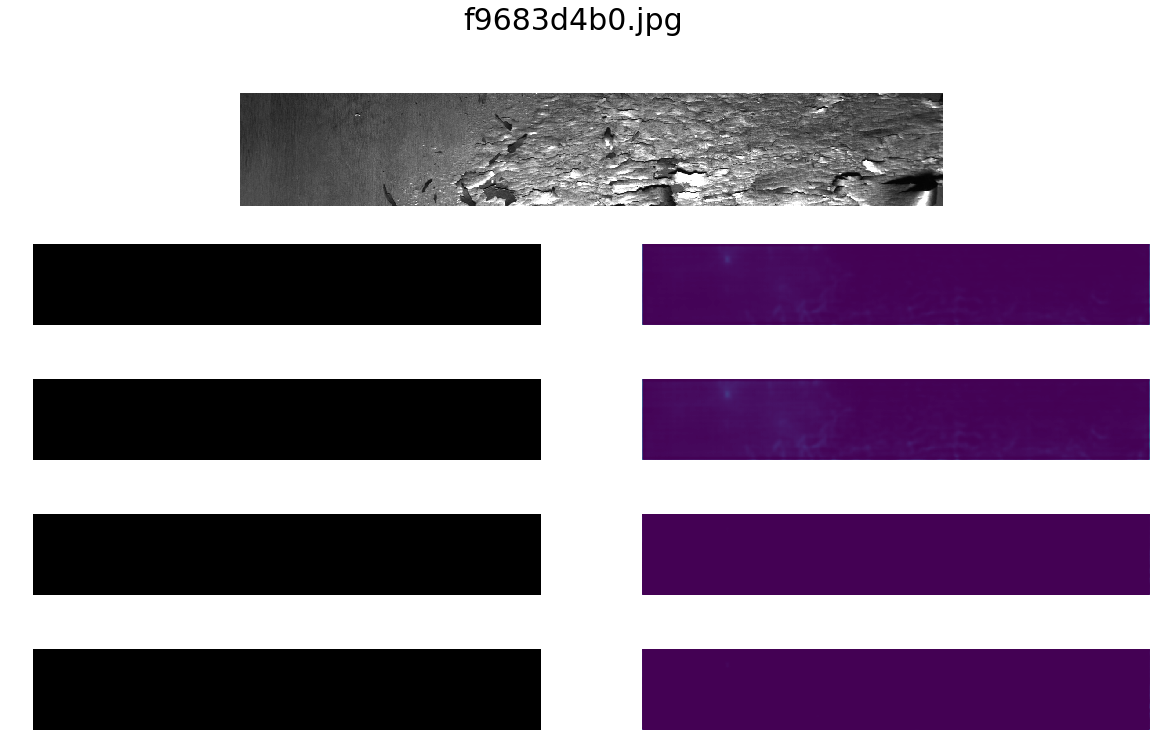

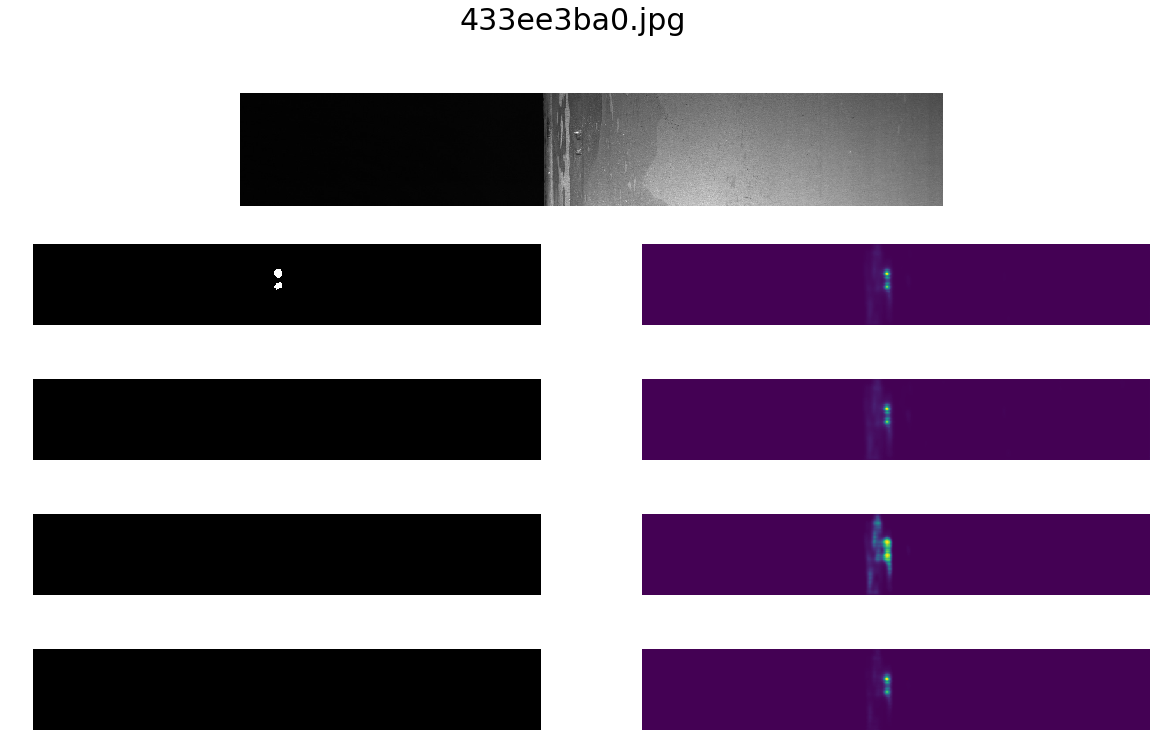

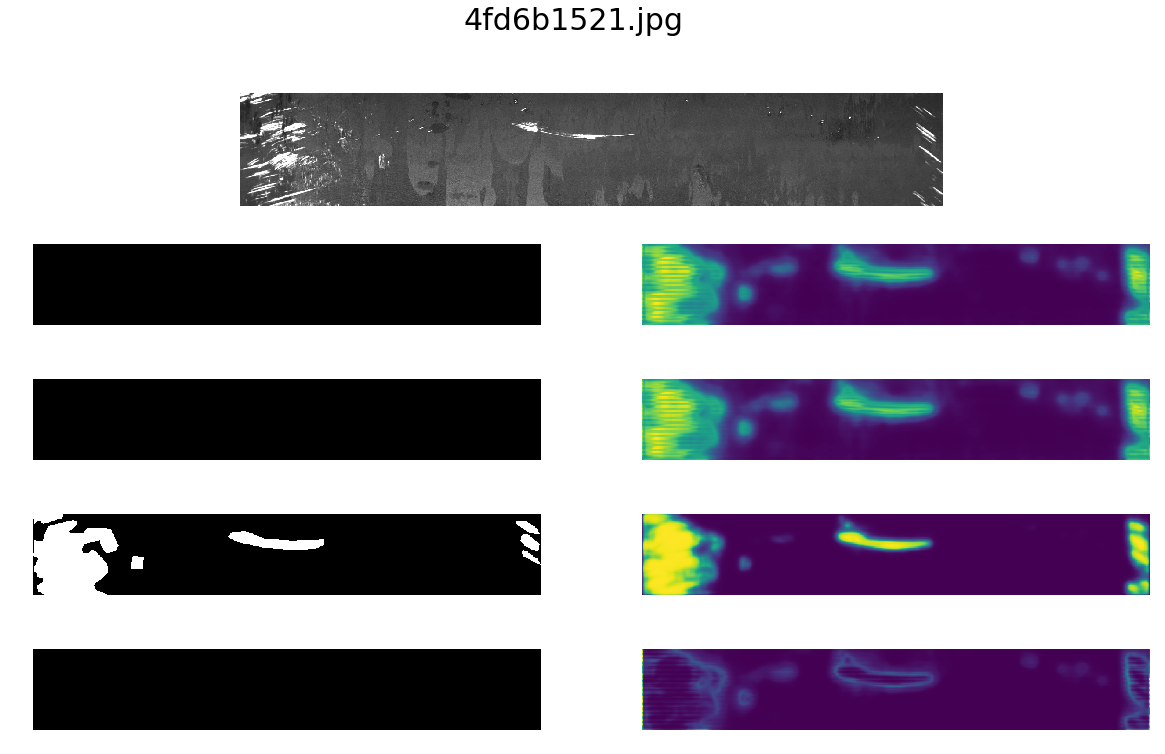

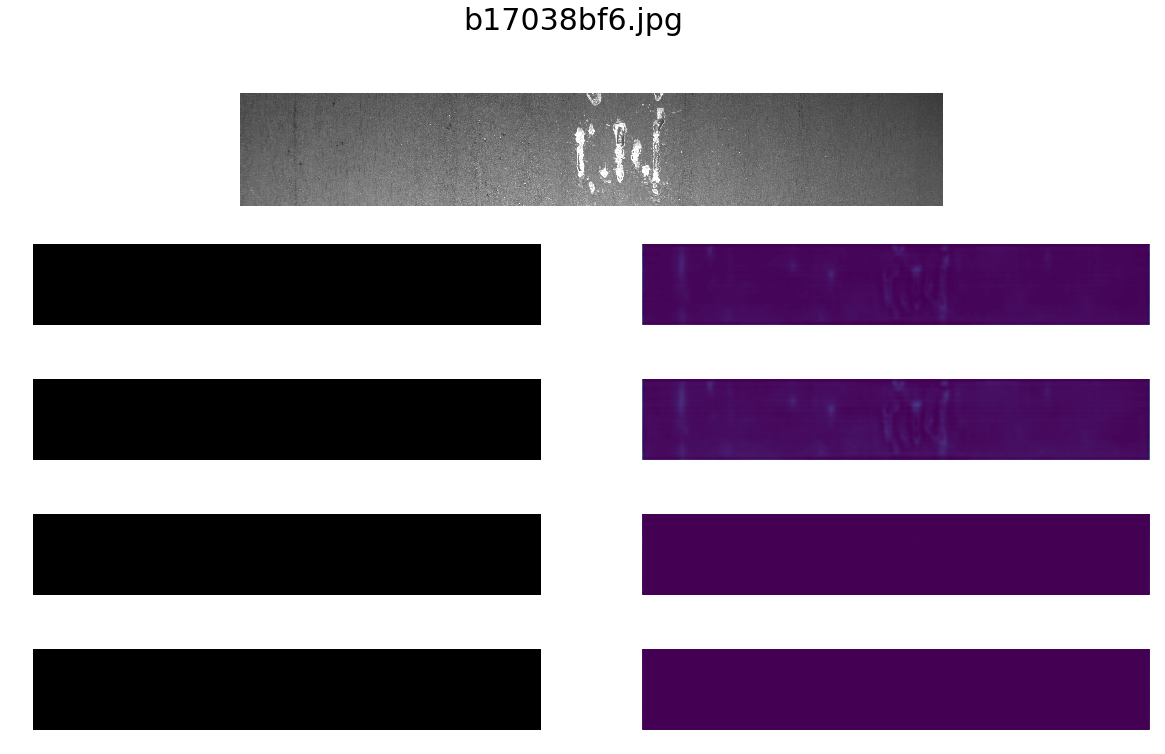

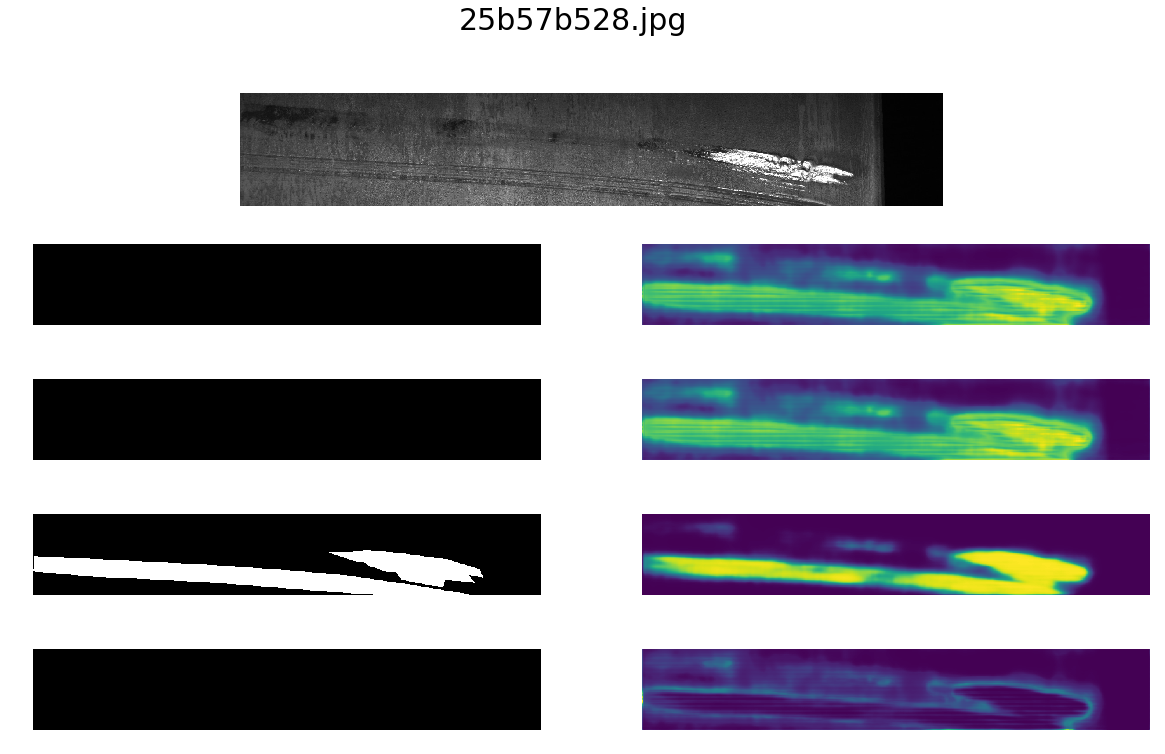

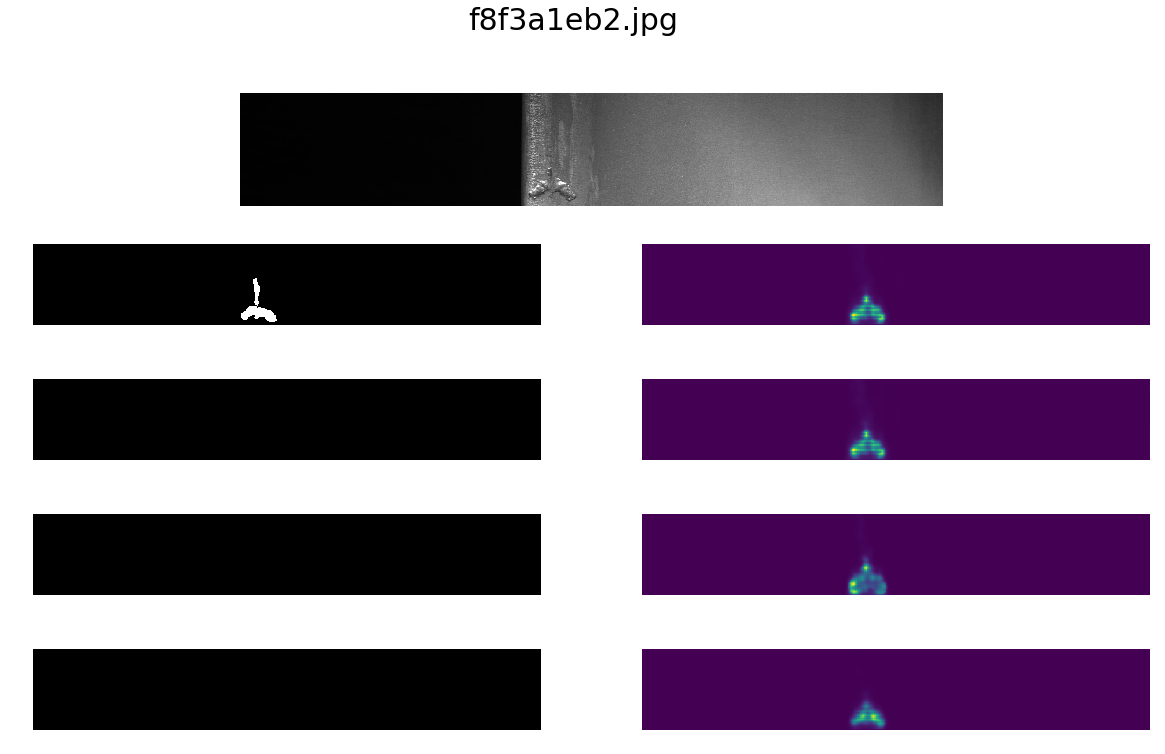

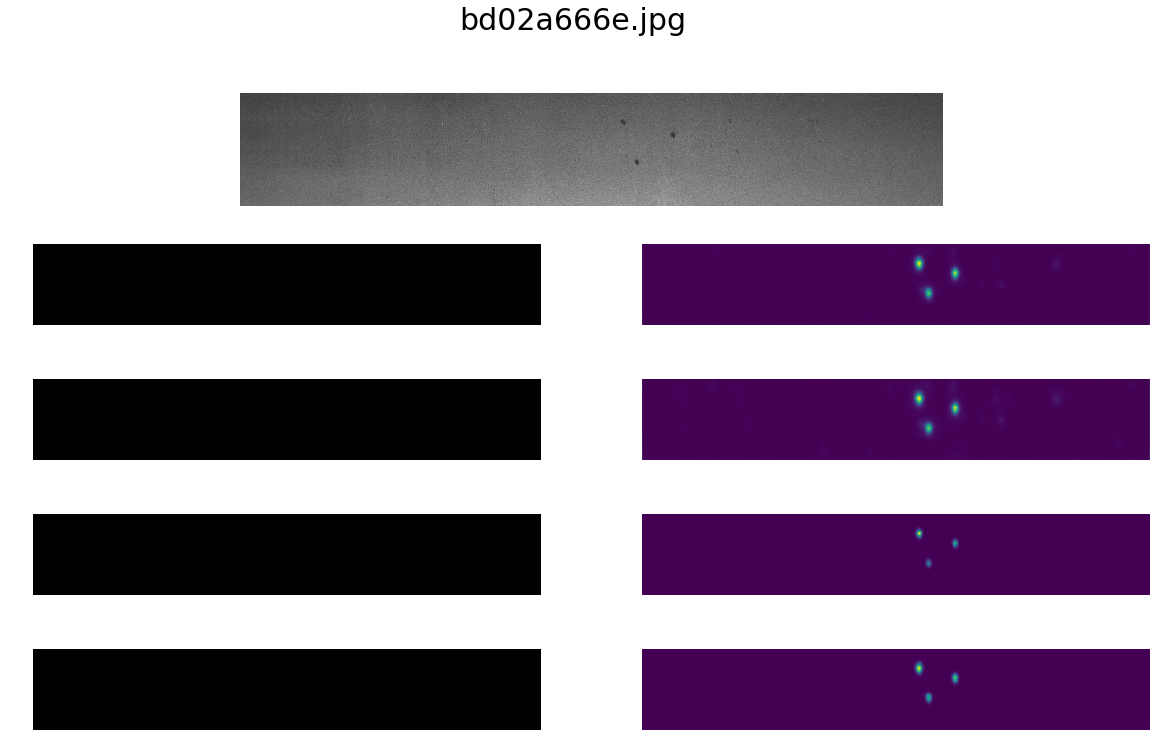

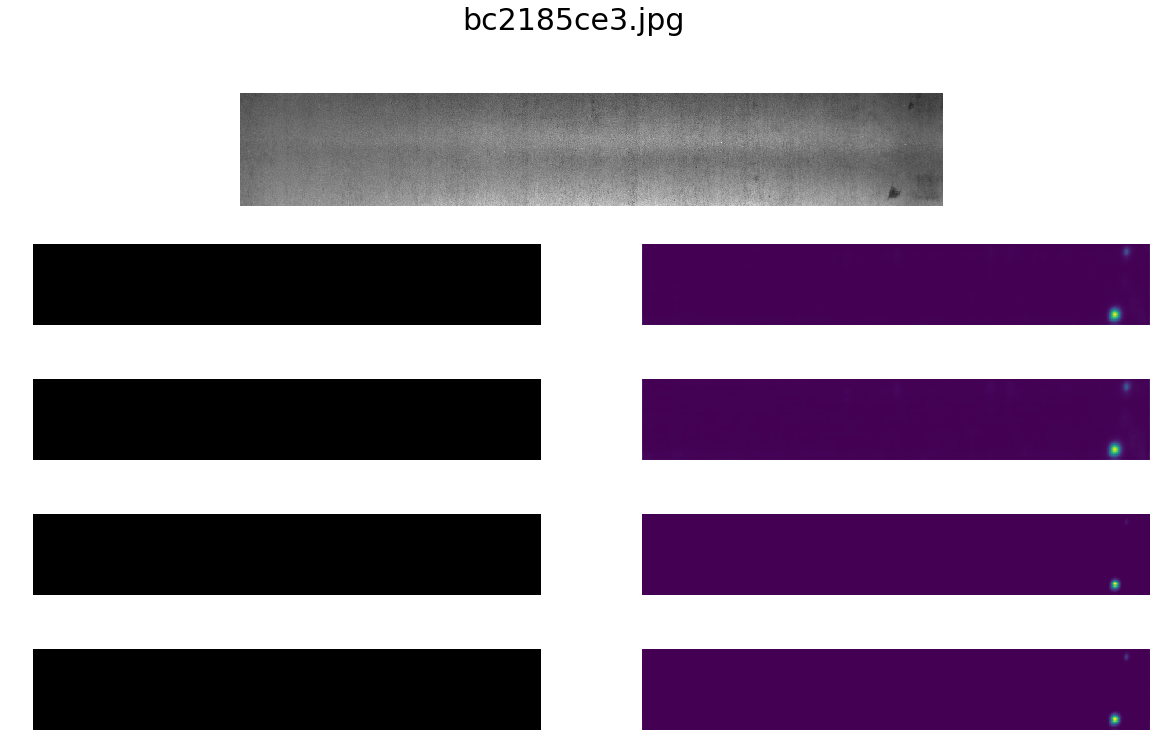

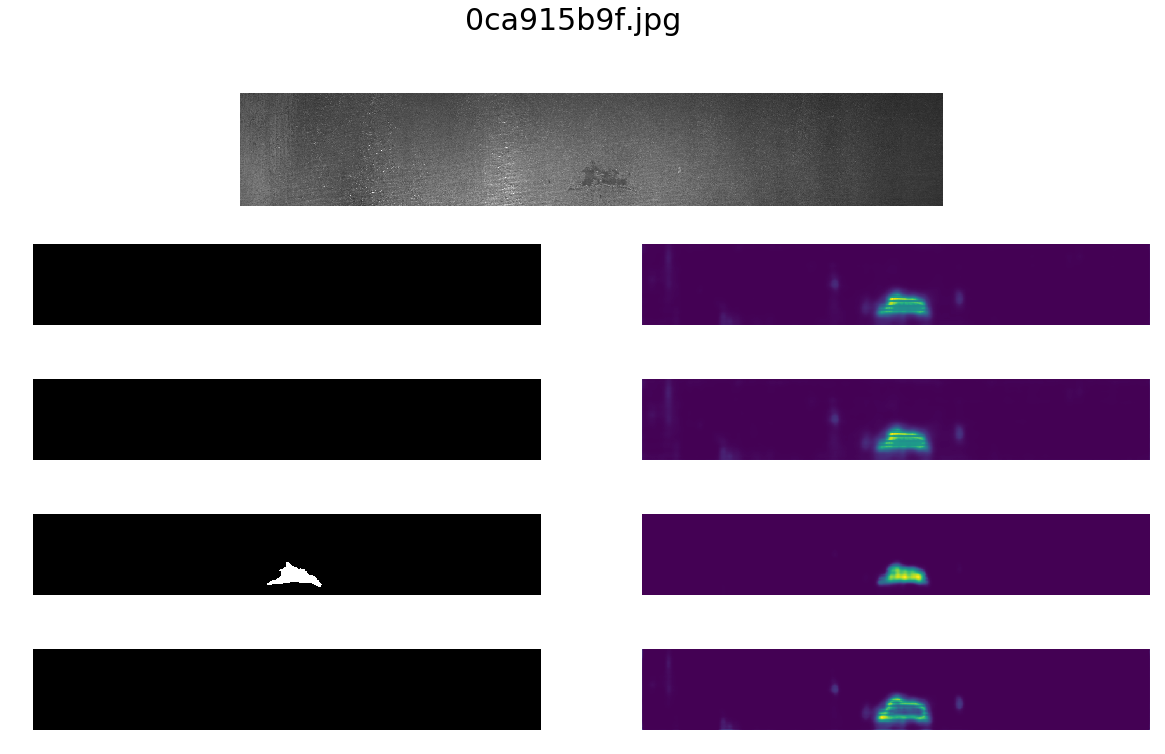

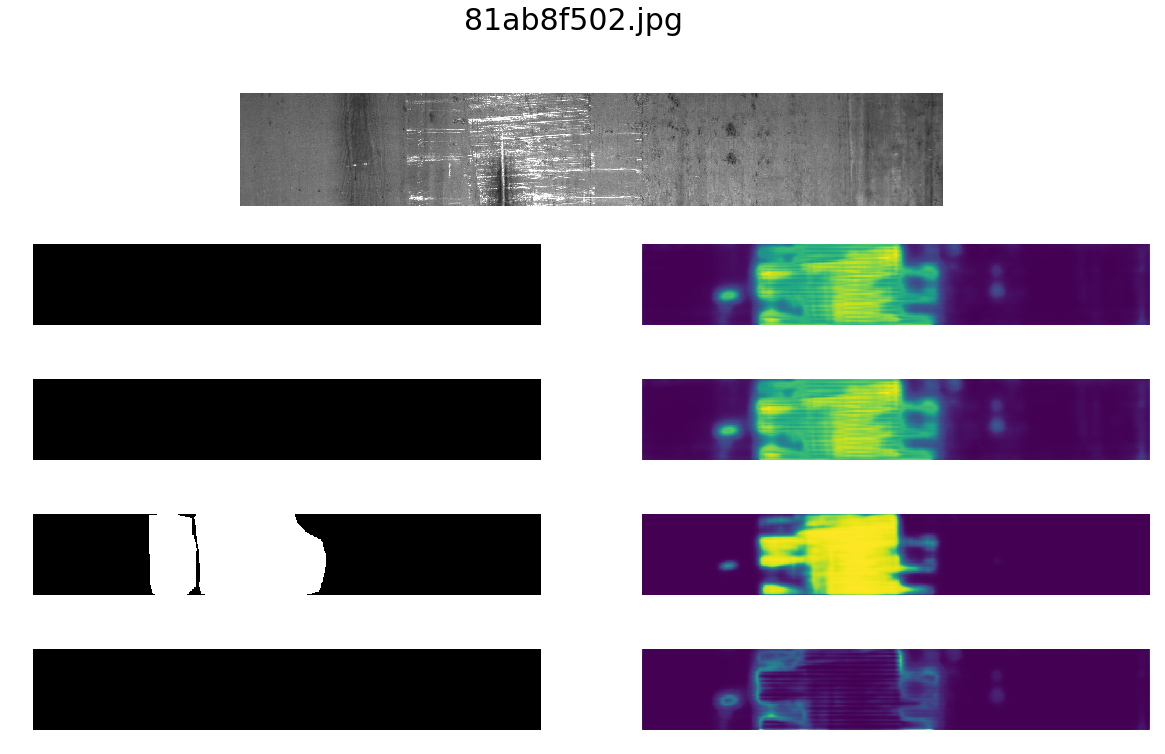

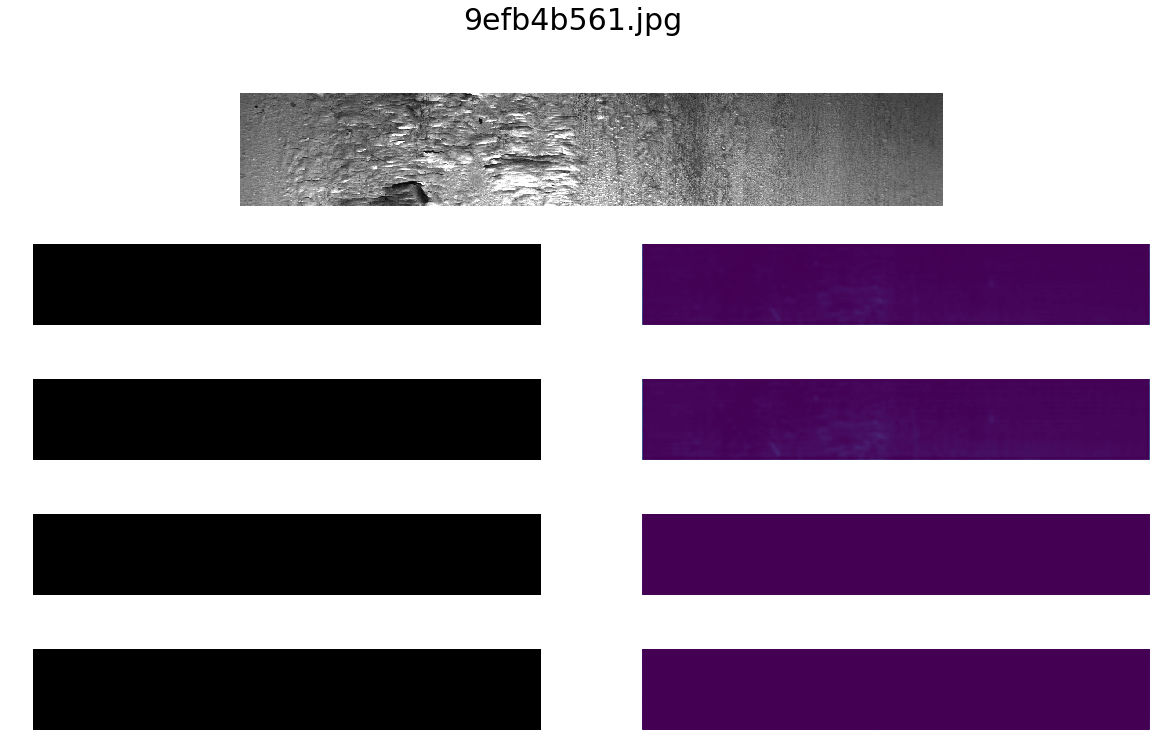

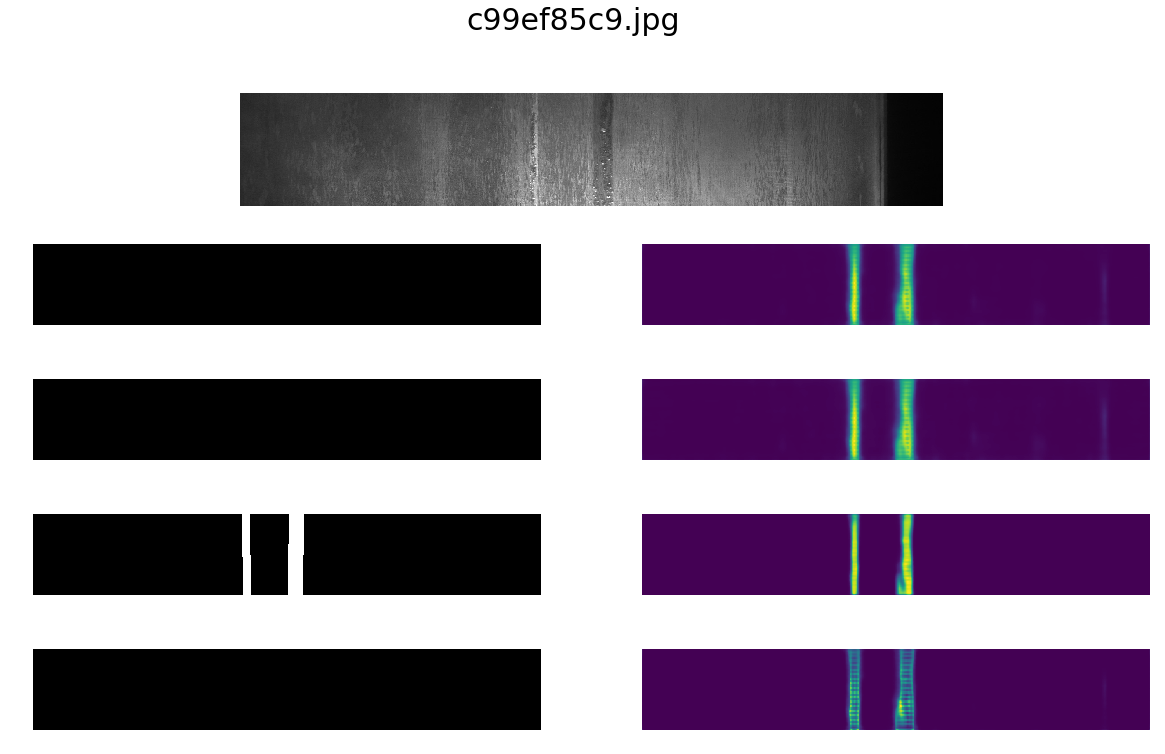

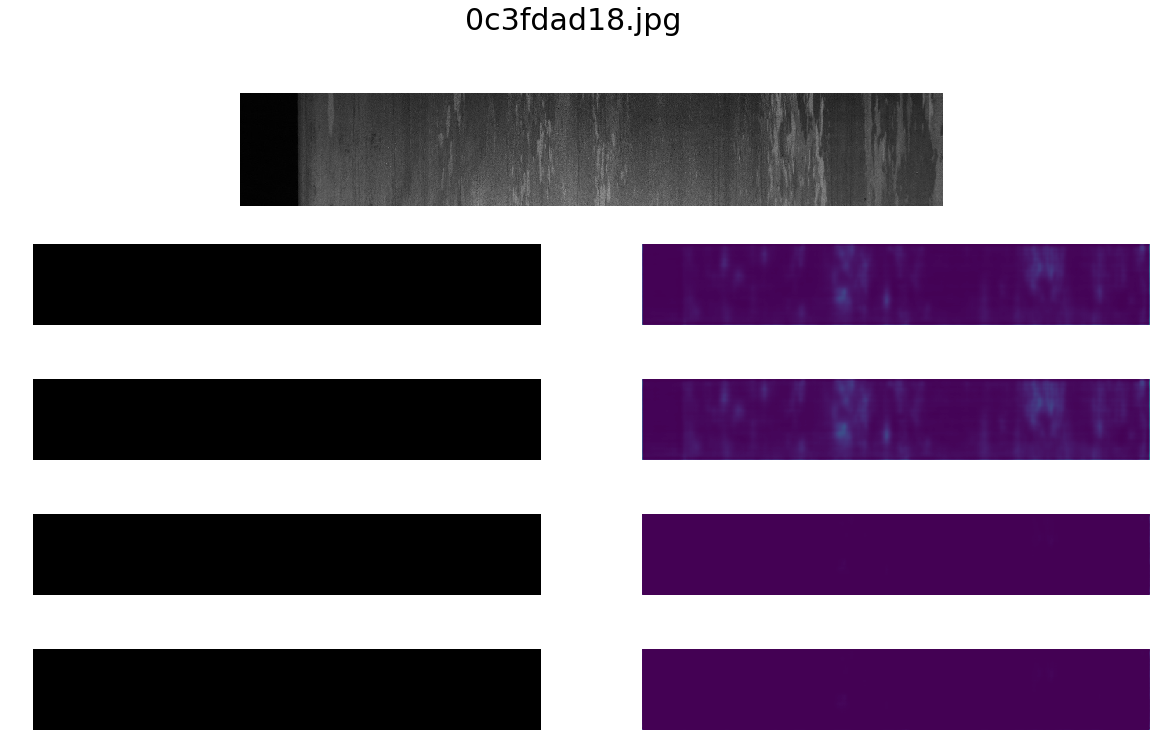

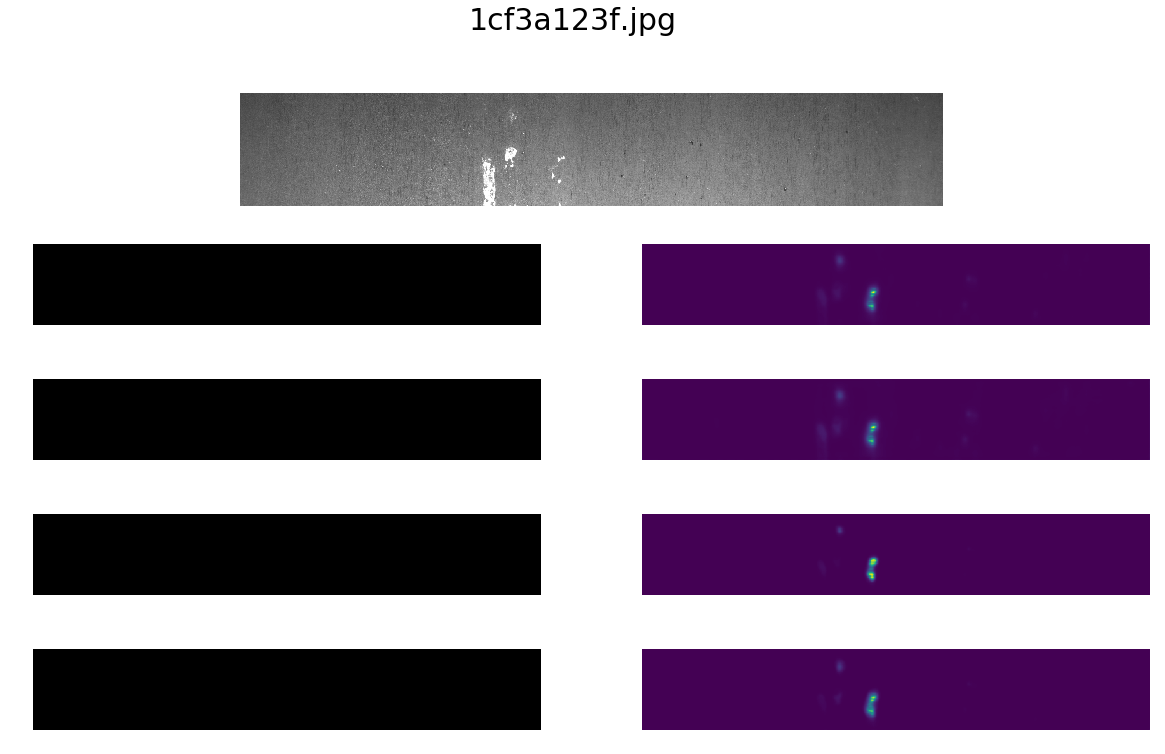

In [100]:
draw_predict_image(random=True)

In [101]:
def cal_iou(y_true, y_pred, channels):
    smooth = 1e-6
    y_true_in = y_true.astype('bool')[:,:,channels]
    y_pred_in = y_pred[:,:,channels]
    true = np.sum(y_true_in)
    pred = np.sum(y_pred_in)
    intersection = np.sum(y_true_in * y_pred_in)
    union = true + pred - intersection
    iou = (intersection+smooth) / (union+smooth)
    iou = np.floor(max(0, (iou - 0.5)*20)) / 10
    return iou

def cal_iou_metric(y_true_in, y_pred_in,channels):
    metric = []
    for y_t, y_p in zip(y_true_in,y_pred_in):
        metric.append(cal_iou(y_t,y_p,channels))
    return np.mean(metric)

In [102]:
thresholds = np.linspace(0.0, 1.0, 31)
iou_calclulated_channels = []
for types in range(4):
    iou_calclulated_channels.append(np.array([cal_iou_metric(val_img,pre_img>threshold , types)
                                                for threshold in tqdm_notebook(thresholds)]))

type 0 defect:  7
type 1 defect:  2
type 2 defect:  15
type 3 defect:  14


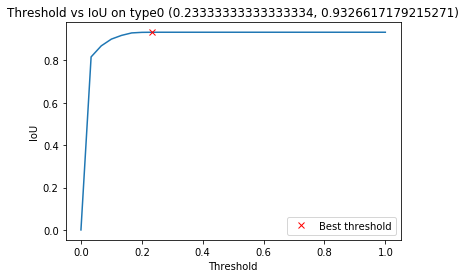

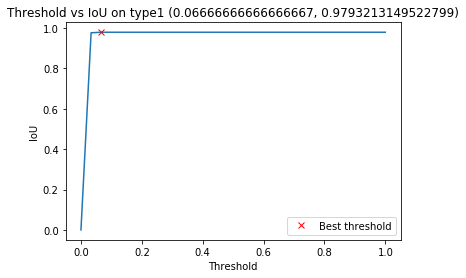

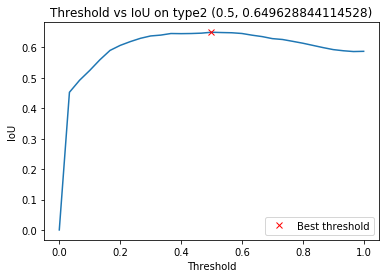

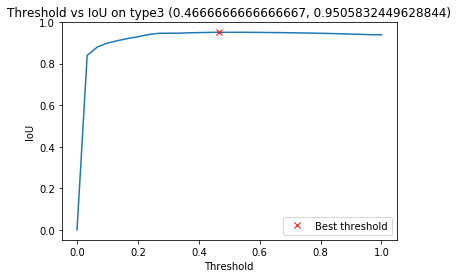

In [103]:
for types in range(4):
    threshold_best_index = np.argmax(iou_calclulated_channels[types]) 
    print('type {} defect: '.format(types),threshold_best_index)
    iou_best = iou_calclulated_channels[types][threshold_best_index]
    threshold_best_cal = thresholds[threshold_best_index]

    plt.figure()
    plt.plot(thresholds,iou_calclulated_channels[types])
    plt.plot(threshold_best_cal,iou_best,'xr', label="Best threshold")
    plt.legend()
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU on type{} ({}, {})".format(types, threshold_best_cal, iou_best))

# Train Classification model

In [48]:
class DatagenClass(Sequence):
    def __init__(self, train_dir = TRAIN_DIR, mask_dir = mask_dir, augmentation = None,
                 batch_size = batch_size, shuffle = True, image_size = image_size,
                 shrink = shrink, preprocess = None, subset = 'train'):
        self.train_dir = train_dir
        self.train_dirs = glob.glob(train_dir+'/*')
        self.mask_df = pd.read_csv(mask_dir)
        self.mask_df.set_index('ImageId_ClassId',inplace=True)
        self.augment = augmentation
        self.batch_size = batch_size
        self.shuffle = shuffle            
        self.image_size = image_size
        self.shrink = shrink                 ## image size shrink
        self.subset = subset
        self.preprocess = preprocess   ## imagenet preprocess
        self.on_epoch_end()

    def __getitem__(self,index):
        # get the indexes
        indexes = self.indexes[(index)*self.batch_size:min((index+1)*self.batch_size,len(self.train_dirs))]

        # list of items
        list_id_items = [self.train_dirs[x] for x in indexes]
        image, mask = self.data_generator(list_id_items)

        if self.augment is None:
            if self.subset == 'train': return image, mask
            else: return image
        else:
            images = [] 
            for x, y in zip(image,mask):
                augment_result = self.augment(image = x)
                images.append(augment_result['image'])
            if self.subset == 'train': return np.array(images), mask
            else: return np.array(images)
        
    def __len__(self):
        return int(np.ceil(len(self.train_dirs)/self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.train_dirs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def data_generator(self,list_id_items):
        batch_size = len(list_id_items)
        w = self.image_size[0]//self.shrink
        h = self.image_size[1]//self.shrink
        
        images = np.empty((batch_size, w, h, 3))
        masks = np.zeros((batch_size, 5))   #5 types of categories
        
        for i , data in enumerate(list_id_items):
            # get source image
            
            image_size = (w, h)
            im = cv2.resize(np.array(Image.open(data)),(h,w))
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

                
            if self.subset == 'train': 
                d_name = data.split('\\')[-1]
                havemask = 0
                for idx in range(4):
                    rle = self.mask_df.loc[d_name+'_{}'.format(idx+1),'EncodedPixels']
                    if rle is not np.nan:
                        masks[i,idx+1] = 1
                        havemask = 1
                if havemask == 0:
                    masks[i,0] = 1

                
            if self.preprocess!=None: im = self.preprocess(im)
            images[i,] = im
            
            
        return np.uint8(images), np.uint8(masks)

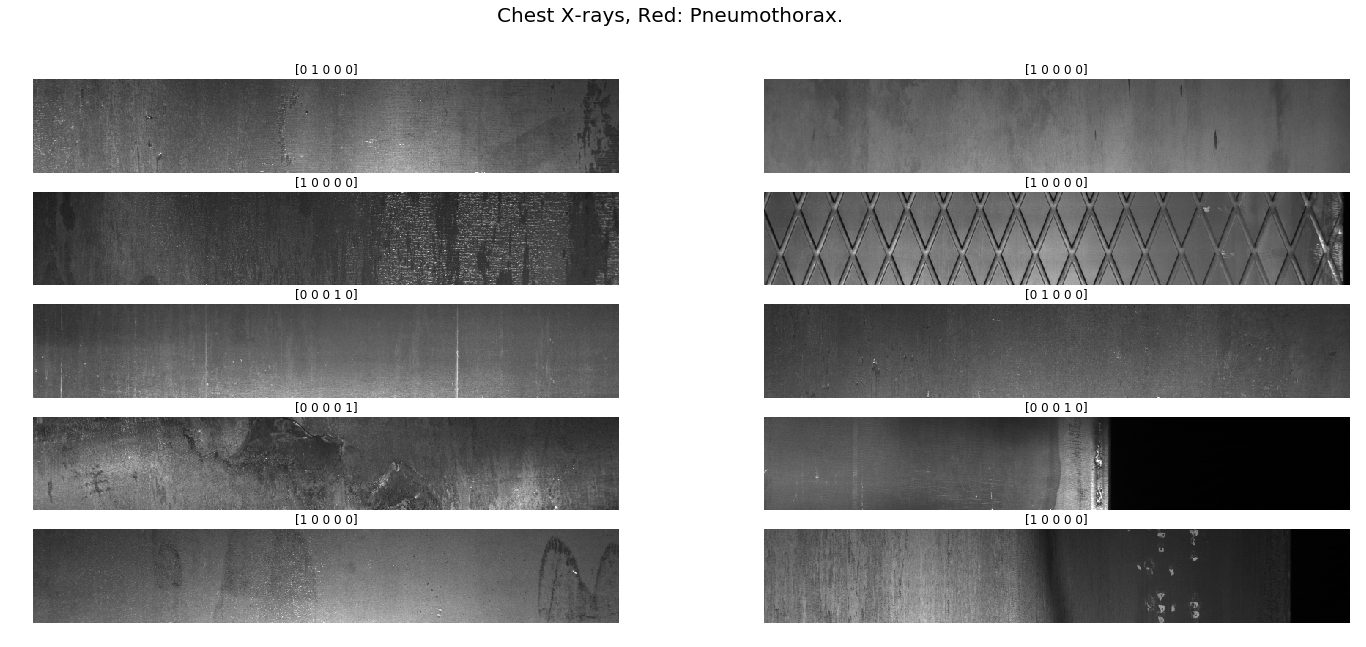

In [49]:
def print_test_data_class(data_gen , total_image , shrink=1, augmentation = None , shuffle = True):
    Dgen = data_gen(batch_size=total_image, shrink=shrink, shuffle=shuffle ,augmentation = augmentation)
    images, masks = Dgen.__getitem__(0)
    fig_width = 2
    fig_height = int(total_image/fig_width)
    fig, axes = plt.subplots(fig_height,fig_width,figsize=(fig_width*12,fig_height*2))

    for i, (im , mk) in enumerate(zip(images,masks)):
        ax = axes[int(i/fig_width),i%fig_width]
        ax.imshow(im.squeeze().astype('uint8'), cmap="bone")
        ax.title.set_text(mk)
        ax.axis('off')
    plt.suptitle("Chest X-rays, Red: Pneumothorax.",fontsize=20)
    
print_test_data_class(DatagenClass,10,shuffle= False,shrink=2)

In [50]:
K.clear_session()
ResNet34, preprocess_input = Classifiers.get('resnet34')
backbone = ResNet34(weights='imagenet', include_top=False, input_shape=(128,800,3), classes = 4)
backbone.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 800, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 806, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 400, 64)  9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

stage3_unit1_bn2 (BatchNormaliz (None, 8, 50, 256)   1024        stage3_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit1_relu2 (Activation) (None, 8, 50, 256)   0           stage3_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 10, 52, 256)  0           stage3_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit1_conv2 (Conv2D)     (None, 8, 50, 256)   589824      zero_padding2d_18[0][0]          
__________________________________________________________________________________________________
stage3_unit1_sc (Conv2D)        (None, 8, 50, 256)   32768       stage3_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_8 (Add

add_16 (Add)                    (None, 4, 25, 512)   0           stage4_unit3_conv2[0][0]         
                                                                 add_15[0][0]                     
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 4, 25, 512)   2048        add_16[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, 4, 25, 512)   0           bn1[0][0]                        
Total params: 21,302,473
Trainable params: 21,287,107
Non-trainable params: 15,366
__________________________________________________________________________________________________


In [51]:
def DNN_block(x, channels):
    x = Dense(channels)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

def cbam_convolution_block(x, filters, size=(3,3), strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = cbam_block(x,filters)
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = cbam_block(x,filters)
    return x


In [52]:
from classification_models import Classifiers
ResNet34, preprocess_input = Classifiers.get('resnet34')


def ResNet34_class(input_shape=(None, None, 3),dropout_rate=0.1):
    backbone = ResNet34(weights='imagenet', include_top=False, input_shape=input_shape, classes = 5)
    input = backbone.input
    x = backbone.get_layer('relu1').output
    x = GlobalAveragePooling2D()(x)
    x = DNN_block(x,1000)
    x = Dropout(dropout_rate)(x)
    x = DNN_block(x,100)
    x = Dropout(dropout_rate)(x)
    output = Dense(5,activation='softmax')(x)
    
    model = Model(input, output)
    model.name = 'ResNet34_class'

    return model

In [53]:
K.clear_session()
model = ResNet34_class((image_size[0]//shrink,image_size[1]//shrink,3),dropout_rate=0.3)
model.summary()
model.compile('adam',loss = 'categorical_crossentropy',metrics =['acc'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 800, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 806, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 400, 64)  9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

stage3_unit1_bn2 (BatchNormaliz (None, 8, 50, 256)   1024        stage3_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit1_relu2 (Activation) (None, 8, 50, 256)   0           stage3_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 10, 52, 256)  0           stage3_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit1_conv2 (Conv2D)     (None, 8, 50, 256)   589824      zero_padding2d_18[0][0]          
__________________________________________________________________________________________________
stage3_unit1_sc (Conv2D)        (None, 8, 50, 256)   32768       stage3_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_8 (Add

add_16 (Add)                    (None, 4, 25, 512)   0           stage4_unit3_conv2[0][0]         
                                                                 add_15[0][0]                     
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 4, 25, 512)   2048        add_16[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, 4, 25, 512)   0           bn1[0][0]                        
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           relu1[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1000)         513000      global_average_pooling2d_1[0][0] 
__________

In [54]:
epochs = 50
batch_size = 28
swa_nb = epochs-5
model_name = 'resnet_class'


snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
swa = SWA(model_name+'_swa.h5',swa_nb)

# Generators
training_generator = DatagenClass(augmentation=AUGMENTATIONS_TRAIN,
                             image_size=image_size,batch_size=batch_size,
                             shrink=shrink,preprocess = None)

validation_generator = DatagenClass(train_dir = VAL_DIR,
                               augmentation=AUGMENTATIONS_TEST,
                               image_size=image_size,batch_size=batch_size,
                               shrink=shrink, preprocess = None)

history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,  
                              use_multiprocessing=False,
                              epochs=epochs,verbose=2,
                              callbacks=snapshot.get_callbacks())

Stochastic weight averaging selected for last 5 epochs.
Epoch 1/50
 - 202s - loss: 0.8554 - acc: 0.7224 - val_loss: 0.6513 - val_acc: 0.7810

Epoch 00001: val_acc improved from -inf to 0.78102, saving model to resnet_class.h5
Epoch 2/50
 - 179s - loss: 0.6118 - acc: 0.7950 - val_loss: 0.6457 - val_acc: 0.7656

Epoch 00002: val_acc did not improve from 0.78102
Epoch 3/50
 - 183s - loss: 0.5195 - acc: 0.8304 - val_loss: 0.5937 - val_acc: 0.8192

Epoch 00003: val_acc improved from 0.78102 to 0.81919, saving model to resnet_class.h5
Epoch 4/50
 - 179s - loss: 0.4488 - acc: 0.8469 - val_loss: 0.4008 - val_acc: 0.8712

Epoch 00004: val_acc improved from 0.81919 to 0.87116, saving model to resnet_class.h5
Epoch 5/50
 - 176s - loss: 0.4250 - acc: 0.8622 - val_loss: 0.4711 - val_acc: 0.8446

Epoch 00005: val_acc did not improve from 0.87116
Epoch 6/50
 - 178s - loss: 0.3985 - acc: 0.8628 - val_loss: 0.5129 - val_acc: 0.8324

Epoch 00006: val_acc did not improve from 0.87116
Epoch 7/50
 - 176s -

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['acc'][1:])
plt.plot(history.history['val_acc'][1:])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model acc')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
#gc.collect()